In [1]:
# Importing objects, libraries and functions to be used in the notebook.
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data import morningstar, Fundamentals
from quantopian.pipeline.factors.morningstar import MarketCap
from quantopian.pipeline import CustomFactor  

from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import builtin, morningstar as mstar
from quantopian.pipeline.classifiers.fundamentals import Sector

from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import mean_information_coefficient
from alphalens.tears import create_information_tear_sheet
from alphalens.tears import create_returns_tear_sheet

import numpy as np

In [2]:
# Momentum is defined as the return of a security over the period of the
# last 11 months with 1-month gap between the end of the 11th month and today.
class Momentum(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252

    def compute(self, today, assets, out, close):
        out[:] = close[-20] / close[0]

# We create a pipeline to define the factor(s).
def make_pipeline():
    
    # Exchange code of a firm.
    exchange = mstar.share_class_reference.exchange_id.latest
    
    # A filter rule is created that returns True only for
    # the stocks from the exchanges listed.
    my_exchanges = exchange.element_of(['NYSE','NYS','NAS','ASE'])
    
    # Market capitalisation, sector code and momentum of a firm.
    market_cap = MarketCap()
    sector = Sector()
    umd = Momentum()
    
    # Defining total_equity, operating_income and interest_expense as
    # corresponding values in the latest income statement and balance sheet.
    total_equity = mstar.balance_sheet.total_equity.latest
    operating_income = mstar.income_statement.operating_income.latest
    interest_expense = mstar.income_statement.interest_expense.latest
    
    # The trading universe is defined as QTradableStocksUS that falls into
    # my_exchanges and has data for umd, total_equity, operating_income,
    # interest_expense, market_cap and sector.
    universe_exchange = QTradableStocksUS() & umd.notnull() & my_exchanges & total_equity.notnull() & market_cap.notnull() & sector.notnull() & operating_income.notnull() & interest_expense.notnull()
    
    # Small and large market cap groups specified as percentile.
    small = (MarketCap(mask=universe_exchange).percentile_between(0, 50))
    large = (MarketCap(mask=universe_exchange).percentile_between(50, 100))
    
    # Create a filter that returns True for the assets in the universe
    # that belong to the given sector(s).
    sec = morningstar.asset_classification.morningstar_sector_code.latest
    my_sec = sec.element_of([101])
    
    # Here the universe redefined as universe_exchange that belongs
    # to the sector(s) in 'my_sec' and falls into either
    # small or large market cap group as defined above.
    # my_sec should be uncommented in case if a speficic sector is wanted.
    '''
    Here are the sector codes that might be used:
    
     -1: 'Misc',  
    101: 'Basic Materials',  
    102: 'Consumer Cyclical',  
    103: 'Financial Services',  
    104: 'Real Estate',  
    205: 'Consumer Defensive',  
    206: 'Healthcare',  
    207: 'Utilities',  
    308: 'Communication Services',  
    309: 'Energy',  
    310: 'Industrials',  
    311: 'Technology' , 
    '''
    universe = universe_exchange & small #& my_sec 
    
    # Book to market is defined as total_equity divided by the market_cap.
    # The value is normalised and ranked in an ascending order.
    bm = total_equity / market_cap
    bm_weights = bm.rank(ascending=True, mask=universe)
    
    # Operating profitability ratio is defined as operating_income subtracted
    # interest_expense divided by the total_equity.
    # The value is normalised and ranked in an ascending order.
    op = (operating_income - interest_expense) / total_equity
    op_weights = op.rank(ascending=True, mask=universe)
  
    # Price momentum values are ranked and normalised in an ascending order.
    umd_weights = umd.rank(ascending=True, mask=universe)
    
    # A class JoinFactors is defined that is used to combine the normalised
    # scores of the factors defined above.
    class JoinFactors(CustomFactor):  
        #inputs = [factor1, factor2, ...] There can be multiple inputs.
        window_length = 1

        def compute(self, today, assets, out, *inputs):  
            array = np.concatenate(inputs, axis=0)  
            out[:] = np.nansum(array, axis=0)  
            out[ np.all(np.isnan(array), axis=0) ] = np.nan
    
    # window_safe declares that scores of the factors are robust to
    # pricing adjustments from splits or dividends. In other words,
    # the value that will be the same no matter what day you are
    # looking back from. This is a required step in order to
    # use them as the input to JoinFactors.
    bm_weights.window_safe = True  
    op_weights.window_safe = True
    umd_weights.window_safe = True

    # The weights of the combined factor. 1, 2, 3 or more factors can be used.
    final_weights = JoinFactors(inputs=[bm_weights, op_weights, umd_weights], mask=universe)
    universe = final_weights.notnan()        
    
    # The Pipeline object filled with the data defined above is returned.
    return Pipeline(
        columns={
                 'bm_weights': bm_weights,
                 'op_weights': op_weights,
                 'umd_weights': umd_weights,
                 'final_weights':final_weights,
                 'exchange': exchange,
                 'market_cap': market_cap,
                 'sector': sector,
                },
        # Screen out all the data points outside the trading universe.
        screen = universe
    )

# Returning the data from the pipeline run over a period of time between 01.01.2003 and 01.01.2005.
factor_data = run_pipeline(make_pipeline(), '2003-1-1', '2005-1-1')

# We preload the pricing data for all the assets in the universe for the time period in question.
# In order to run the analysis propperly the pricing data should cover the period set in factor_data
# It is also recommended to use "open_price" as the fields parameter.
pricing_data = get_pricing(factor_data.index.levels[1], '2002-12-1', '2005-6-1', fields='open_price')

In [3]:
#Show top 30 lines of the factor_data.
factor_data.head(30)

bm_weights exchange  \
2003-01-02 00:00:00+00:00 Equity(41 [ARCB])        279.0      NAS   
                          Equity(85 [ACF])         527.0     NYSE   
                          Equity(88 [ACI])         247.0     NYSE   
                          Equity(110 [RAMP])       191.0      NAS   
                          Equity(115 [ADCT])       201.0      NAS   
                          Equity(154 [AEM])         43.0     NYSE   
                          Equity(166 [AES])        548.0     NYSE   
                          Equity(197 [AGCO])       239.0     NYSE   
                          Equity(209 [AM])         475.0     NYSE   
                          Equity(289 [MATX])       531.0     NYSE   
                          Equity(300 [ALK])        545.0     NYSE   
                          Equity(301 [ALKS])         9.0      NAS   
                          Equity(353 [AME])        117.0     NYSE   
                          Equity(374 [AMLN])        13.0      NAS   
                          Equity(391 [AMH])        515.0     NYSE   
                          Equity(398 [AMSY])       431.0      NAS   
                          Equity(417 [ANDW])       442.0      NAS   
                          Equity(430 [ANN])        403.0     NYSE   
                          Equity(465 [APH])         26.0     NYSE   
                          Equity(477 [APPB])       111.0      NAS   
                          Equity(510 [ARG])        207.0     NYSE   
                          Equity(538 [ARW])        483.0     NYSE   
                          Equity(539 [ARXX])       329.0      NAS   
                          Equity(559 [ASH])        535.0     NYSE   
                          Equity(595 [GAS])        280.0     NYSE   
                          Equity(607 [ATML])       464.0      NAS   
                          Equity(624 [ATW])        365.0     NYSE   
                          Equity(661 [AVT])        538.0     NYSE   
                          Equity(695 [AZR])        481.0     NYSE   
                          Equity(755 [BC])         380.0     NYSE   

                                              final_weights    market_cap  \
2003-01-02 00:00:00+00:00 Equity(41 [ARCB])          1113.0  6.440801e+08   
                          Equity(85 [ACF])           1023.0  1.183216e+09   
                          Equity(88 [ACI])            654.0  1.130928e+09   
                          Equity(110 [RAMP])          743.0  1.373709e+09   
                          Equity(115 [ADCT])          274.0  1.665300e+09   
                          Equity(154 [AEM])           647.0  1.242844e+09   
                          Equity(166 [AES])           573.0  1.642279e+09   
                          Equity(197 [AGCO])         1000.0  1.657966e+09   
                          Equity(209 [AM])           1025.0  1.040538e+09   
                          Equity(289 [MATX])         1124.0  5.604131e+08   
                          Equity(300 [ALK])           913.0  5.753150e+08   
                          Equity(301 [ALKS])          619.0  4.059156e+08   
                          Equity(353 [AME])          1099.0  1.284909e+09   
                          Equity(374 [AMLN])          589.0  1.321427e+09   
                          Equity(391 [AMH])          1077.0  1.102787e+09   
                          Equity(398 [AMSY])          865.0  5.067723e+08   
                          Equity(417 [ANDW])          597.0  1.010722e+09   
                          Equity(430 [ANN])          1147.0  9.325433e+08   
                          Equity(465 [APH])           891.0  1.637534e+09   
                          Equity(477 [APPB])         1064.0  1.281339e+09   
                          Equity(510 [ARG])          1057.0  1.234440e+09   
                          Equity(538 [ARW])           687.0  1.277761e+09   
                          Equity(539 [ARXX])          521.0  4.143690e+08   
                          Equity(559 [ASH])           925.

In [4]:
# Count the unique assets in factor_data.
assets = factor_data.index.levels[1].unique()
len(assets)

1198

Dropped 5.1% entries from factor data: 5.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


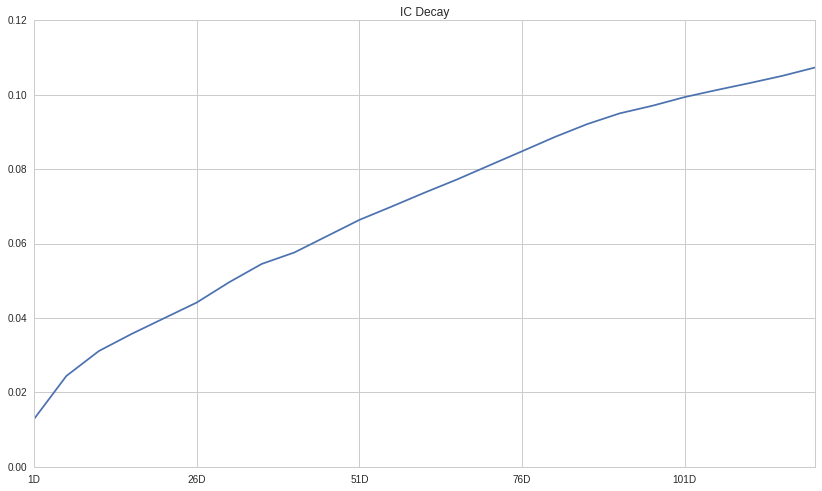

In [5]:
# Plot the mean information coefficient decay.
# The graph allows to see how long does the predicting power last.
longest_look_forward_period = 126 # week = 5, month = 21, quarter = 63, year = 252
range_step = 5


merged_data = get_clean_factor_and_forward_returns(
    # Here the factor of choice should be referred. 
    # For example, 'bm_weights', 'op_weights', 'umd_weights' or 'final_weights'.
    factor=factor_data['bm_weights'],
    prices=pricing_data,
    periods=range(1, longest_look_forward_period, range_step)
)

mean_information_coefficient(merged_data).plot(title="IC Decay")

Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,30D,60D,90D
IC Mean,0.043,0.066,0.083
IC Std.,0.076,0.067,0.060
Risk-Adjusted IC,0.563,0.978,1.385
t-stat(IC),12.649,21.974,31.114
p-value(IC),0.000,0.000,0.000
IC Skew,0.467,0.425,0.156
IC Kurtosis,0.305,-0.185,-0.992


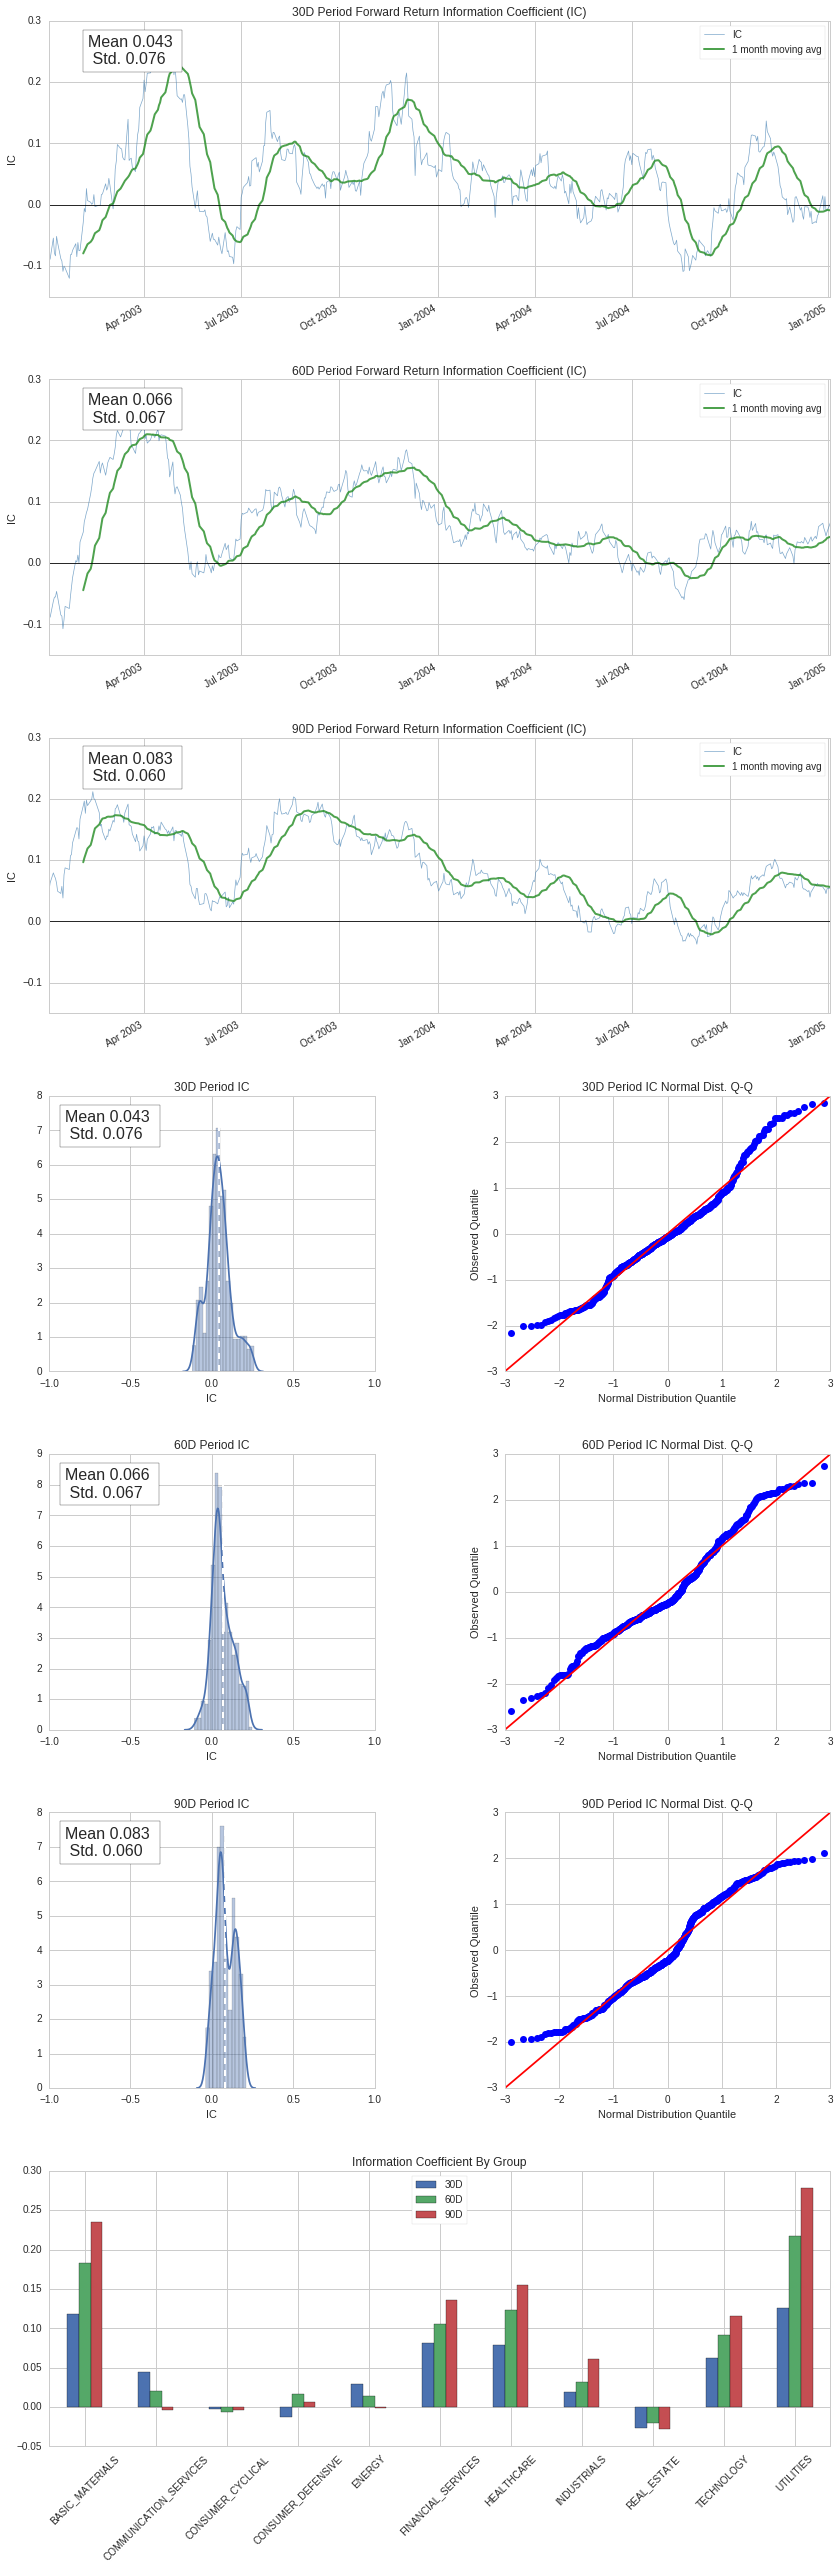

Returns Analysis


,30D,60D,90D
Ann. alpha,0.030,0.029,0.034
beta,0.082,0.105,0.086
Mean Period Wise Return Top Quantile (bps),118.490,133.190,131.999
Mean Period Wise Return Bottom Quantile (bps),-30.675,-37.600,-41.748
Mean Period Wise Spread (bps),149.165,170.176,173.195


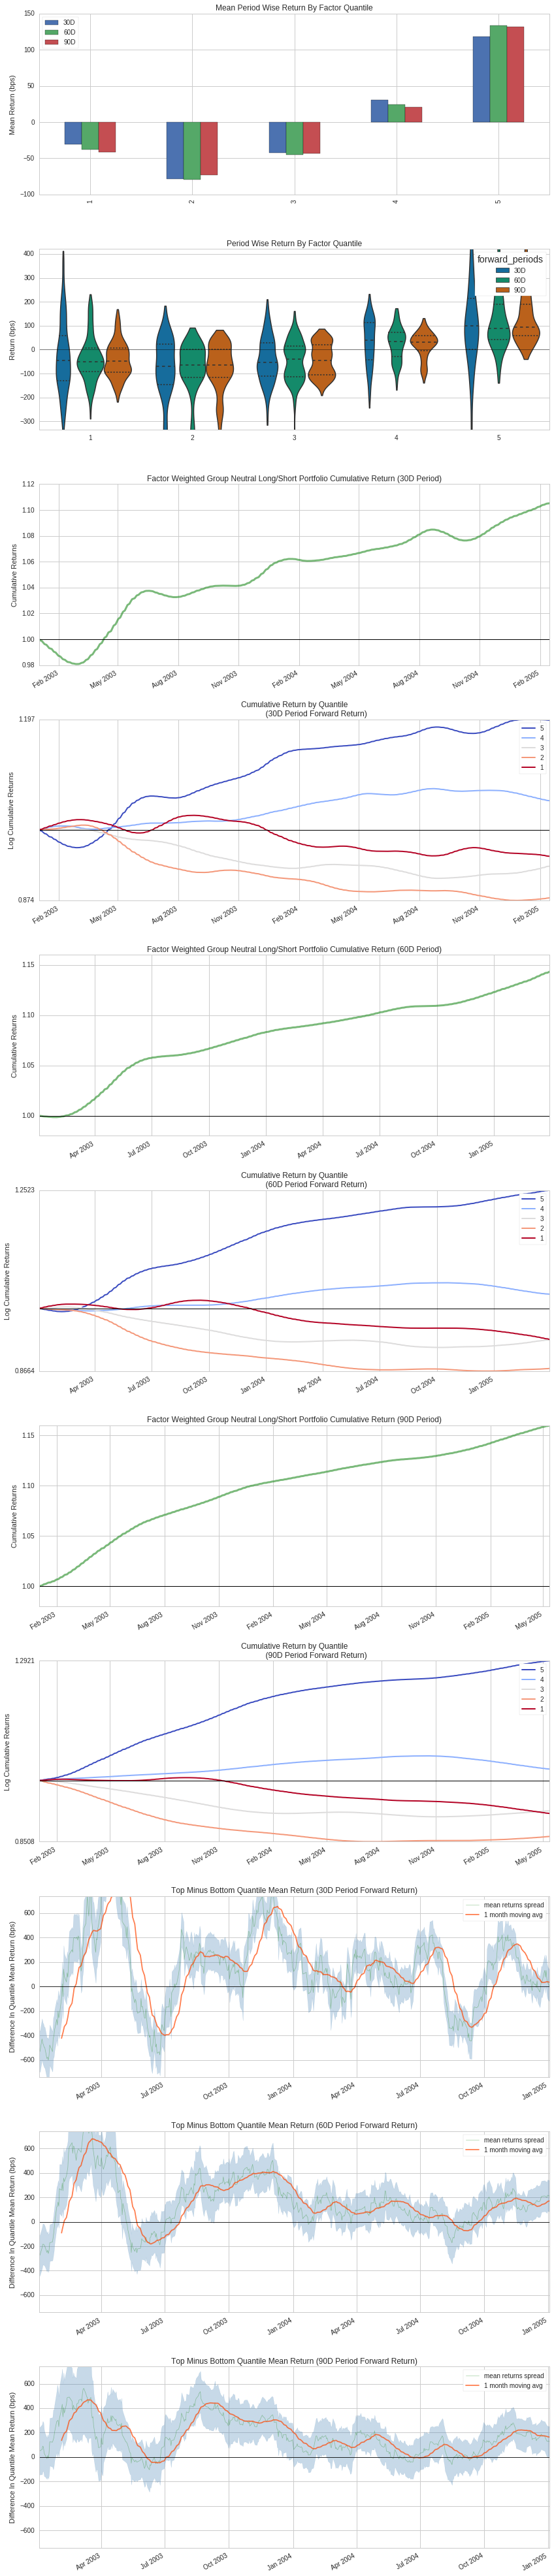

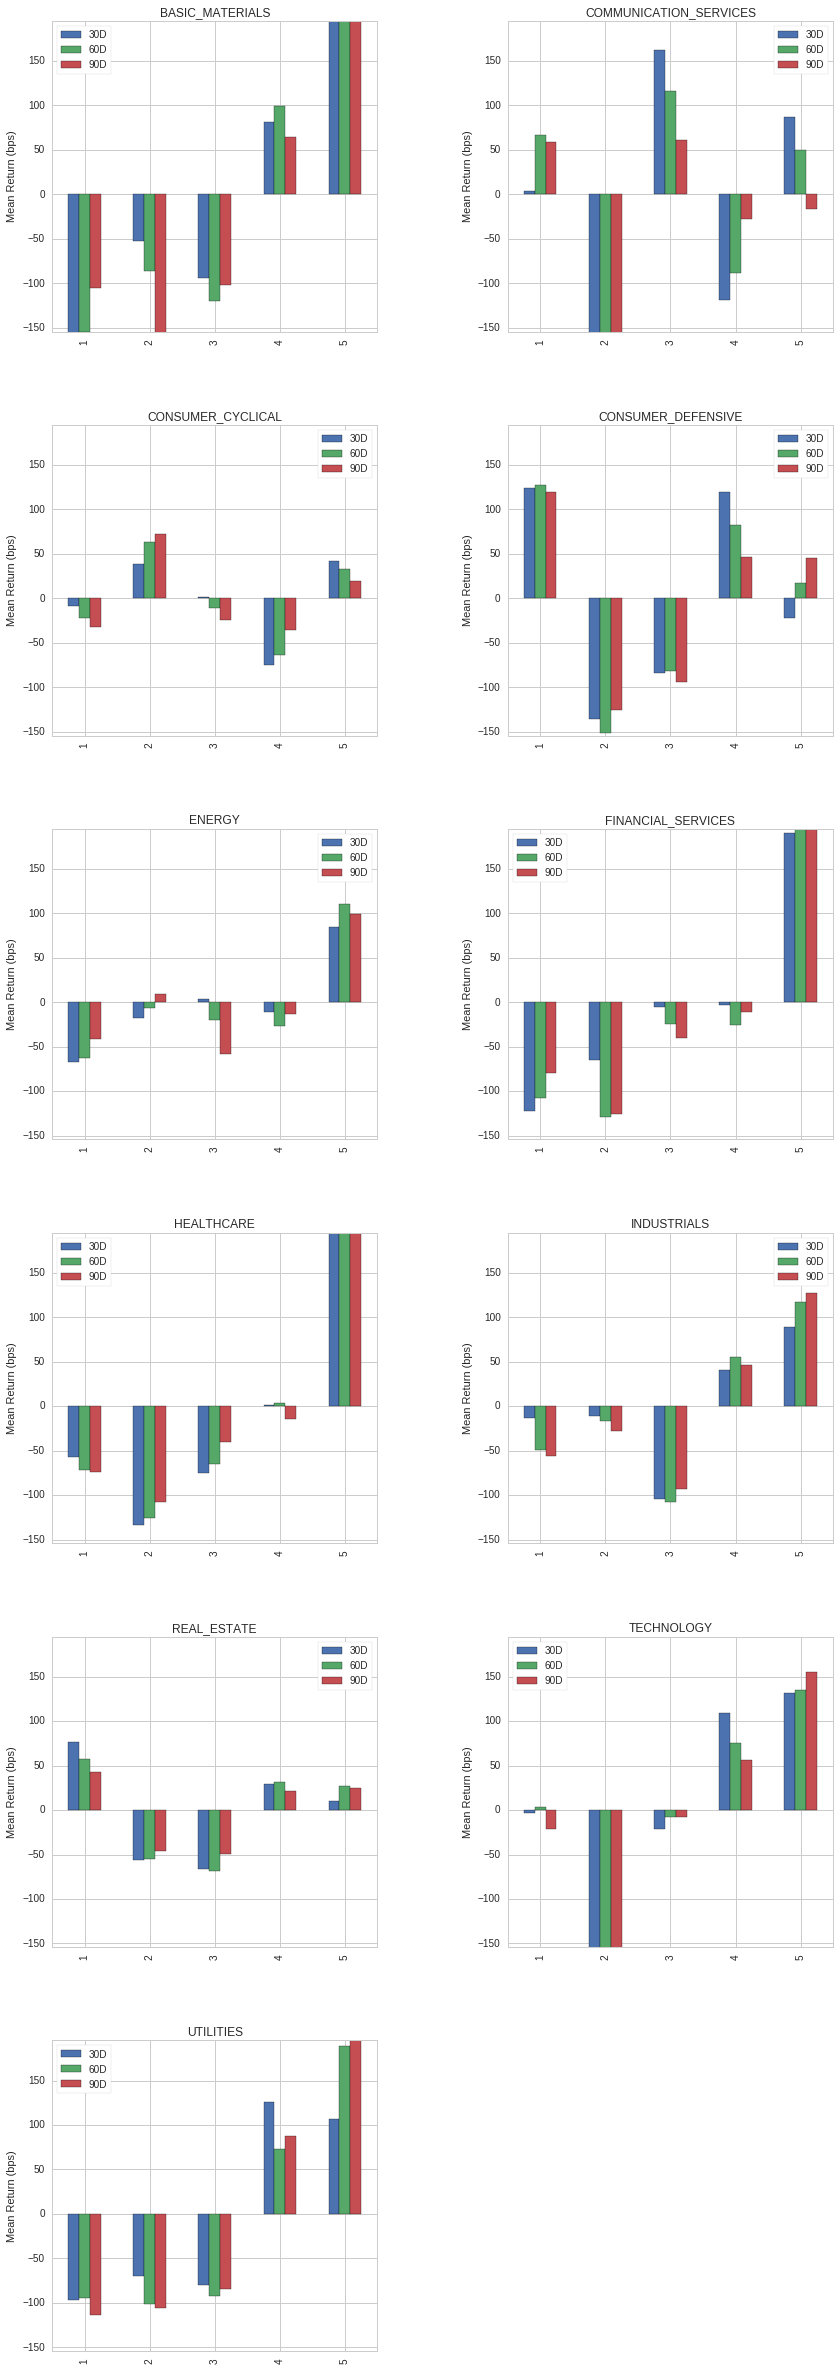

In [6]:
# Tis cell generates a set of descriptive statistics about the factor as well as a few useful graphs.
sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

merged_data = get_clean_factor_and_forward_returns(
    # Here the factor of choice should be referred. 
    # For example, 'bm_weights', 'op_weights', 'umd_weights' or 'final_weights'.
    factor=factor_data['bm_weights'],
    prices=pricing_data,
    groupby=factor_data['sector'],
    groupby_labels=sector_labels,
    binning_by_group=True,
    # Custom forward returns periods could be selected here. 
    periods=(30,60,90)
)

create_information_tear_sheet(merged_data, by_group=True, group_neutral=True)
create_returns_tear_sheet(merged_data, by_group=True, group_neutral=True)